##+GM STAB 2YR, STA -HURST

In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline, CustomFilter, CustomFactor
from quantopian.pipeline.data import Fundamentals 
from quantopian.pipeline.data import factset
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector  
from quantopian.pipeline.classifiers.morningstar import Sector 
from quantopian.pipeline.filters import QTradableStocksUS, Q1500US, Q500US
from quantopian.pipeline.filters.eventvestor import IsAnnouncedAcqTarget
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data.psychsignal import aggregated_twitter_withretweets_stocktwits as st
from quantopian.pipeline.data.zacks import EarningsSurprises
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import Latest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats.mstats import winsorize
from zipline.utils.numpy_utils import ( repeat_first_axis, repeat_last_axis )

In [2]:
from quantopian.pipeline.factors import ( CustomFactor, BusinessDaysSincePreviousEvent, 
                                         BusinessDaysUntilNextEvent, SimpleMovingAverage, 
                                         AverageDollarVolume, Returns, RSI, 
                                         RollingLinearRegressionOfReturns, RollingSpearmanOfReturns, 
                                         AnnualizedVolatility, Returns, DailyReturns, EWMA)

In [3]:
import talib
import pandas as pd
import numpy as np
from time import time

In [4]:
import alphalens as al
import pyfolio as pf
from scipy import stats
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.svm import SVC, OneClassSVM, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics
from sklearn.metrics import classification_report
from scipy.stats.mstats import gmean
from sklearn.cluster import SpectralClustering
from collections import Counter

In [5]:
def run_pipeline_chunks(pipe, start_date, end_date, chunks_len = None):
    
    chunks  = []
    current = pd.Timestamp(start_date)
    end     = pd.Timestamp(end_date)
    step    = pd.Timedelta(weeks=26) if chunks_len is None else chunks_len
    
    start_pipeline_timer = time()
    
    while current <= end:
        
        current_end = current + step
        if current_end > end:
            current_end = end
        
        start_timer = time()
        print 'Running pipeline:', current, ' - ', current_end
        results = run_pipeline(pipe, current.strftime("%Y-%m-%d"), current_end.strftime("%Y-%m-%d"))
        chunks.append(results)
        
        # pipeline returns more days than requested (if no trading day), so get last date from the results
        current_end = results.index.get_level_values(0)[-1].tz_localize(None)
        current = current_end + pd.Timedelta(days=1)
        
        end_timer = time()
        print "Time to run this chunk of the pipeline %.2f secs" % (end_timer - start_timer)
        
    end_pipeline_timer = time()
    print "Time to run the entire pipeline %.2f secs" % (end_pipeline_timer - start_pipeline_timer)
    return pd.concat(chunks)

In [6]:
WIN_LIMIT = 0.0
N_FACTOR_WINDOW = 5 
N_CLUSTERS = 5
TAU = 5
ALPHA_SMOOTH = 1-np.exp(-1.0/TAU)

In [7]:
def preprocess(a):
    
    a = np.nan_to_num(a - np.nanmean(a))
    
    a = winsorize(a, limits=[WIN_LIMIT,WIN_LIMIT])

    return preprocessing.scale(a)

In [8]:
def normalize(x):
    
    r = x - x.mean()
    denom = r.abs().sum()
    
    return r/denom  

In [9]:
def _slope(ts):
    x = np.arange(len(ts))  
    log_ts = np.log(ts)  
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)  
    annualized_slope = (np.power(np.exp(slope), 250) - 1) 
    return annualized_slope * (r_value ** 2) 

In [10]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

In [11]:
has_data = (factset.Fundamentals.capex_assets_qf.latest.notnull()
            & factset.Fundamentals.zscore_qf.latest.notnull()
            & Fundamentals.fcf_yield.latest.notnull()
            & Fundamentals.long_term_debt.latest.notnull()
            & Fundamentals.current_ratio.latest.notnull()
            & factset.Fundamentals.ppe_gross.latest.notnull()
            & Fundamentals.growth_score.latest.notnull()
            & factset.Fundamentals.ebit_oper_mgn_qf.latest.notnull()
            & Fundamentals.assets_turnover.latest.notnull()
            & factset.Fundamentals.quick_ratio_qf.latest.notnull()
)

In [12]:
market_cap = Fundamentals.market_cap.latest > 1e8 # Market_Cap over 100mil
is_liquid = AverageDollarVolume(window_length=21).percentile_between(95, 100)    

In [13]:
is_tradeable = (QTradableStocksUS()
                & is_liquid
                & has_data
                & market_cap)

In [14]:
def make_factors():
    
    class MessageSum(CustomFactor):
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close, stocktwits.bull_scored_messages, stocktwits.bear_scored_messages, stocktwits.total_scanned_messages]
        window_length = 21
        window_safe = True
        def compute(self, today, assets, out, high, low, close, bull, bear, total):
            v = np.nansum((high-low)/close, axis=0)
            out[:] = preprocess(v*np.nansum(total*(bear-bull), axis=0))
                
    class fcf(CustomFactor):
        inputs = [Fundamentals.fcf_yield]
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, fcf_yield):
            out[:] = preprocess(np.nan_to_num(fcf_yield[-1,:]))
                
    class mean_rev(CustomFactor):   
        inputs = [USEquityPricing.high,USEquityPricing.low,USEquityPricing.close]
        window_length = 30
        window_safe = True
        def compute(self, today, assets, out, high, low, close):
            
            p = (high+low+close)/3
 
            m = len(close[0,:])
            n = len(close[:,0])
                
            b = np.zeros(m)
            a = np.zeros(m)
                
            for k in range(10,n+1):
                price_rel = np.nanmean(p[-k:,:],axis=0)/p[-1,:]
                wt = np.nansum(price_rel)
                b += wt*price_rel
                price_rel = 1.0/price_rel
                wt = np.nansum(price_rel)
                a += wt*price_rel
                
            out[:] = preprocess(b-a)
                
    class volatility(CustomFactor):
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close, USEquityPricing.volume]
        window_length = 5
        window_safe = True
        def compute(self, today, assets, out, high, low, close, volume):
            vol = np.nansum(volume,axis=0)*np.nansum(np.absolute((high-low)/close),axis=0)
            out[:] = preprocess(-vol)
                
    class growthscore(CustomFactor):
        inputs = [Fundamentals.growth_score]
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, growth_score):
            out[:] = preprocess(growth_score[-1,:])
                
    class MoneyflowVolume5d(CustomFactor):
        inputs = (USEquityPricing.close, USEquityPricing.volume)
        window_length = 6
        window_safe = True
        def compute(self, today, assets, out, close_extra, volume_extra):
            close = close_extra[1:]
            volume = volume_extra[1:]
                
            dollar_volume = close * volume
            denominator = dollar_volume.sum(axis=0)
                
            difference = np.diff(close_extra, axis=0)
            direction = np.where(difference > 0, 1, -1)
            numerator = (direction * dollar_volume).sum(axis=0)
                
            out[:] = preprocess(-np.divide(numerator, denominator))
                
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252
        window_safe = True
        _x = np.arange(window_length)
        _x_var = np.var(_x)
 
        def compute(self, today, assets, out, close):
            
            x_matrix = repeat_last_axis(
            (self.window_length - 1) / 2 - self._x,
            len(assets),
            )
 
            y_bar = np.nanmean(close, axis=0)
            y_bars = repeat_first_axis(y_bar, self.window_length)
            y_matrix = close - y_bars
 
            out[:] = preprocess(-np.divide(
            (x_matrix * y_matrix).sum(axis=0) / self._x_var,
            self.window_length
            ))
                
    class SalesGrowth(CustomFactor):
        inputs = [factset.Fundamentals.sales_gr_qf]
        window_length = 2*252
        window_safe = True
        def compute(self, today, assets, out, sales_growth):
            sales_growth = np.nan_to_num(sales_growth)
            sales_growth = preprocessing.scale(sales_growth,axis=0)
            out[:] = preprocess(sales_growth[-1])
 
    class GrossMarginChange(CustomFactor):
        window_length = 2*252
        inputs = [factset.Fundamentals.ebit_oper_mgn_qf]
        window_safe = True
        def compute(self, today, assets, out, ebit_oper_mgn):
            ebit_oper_mgn = np.nan_to_num(ebit_oper_mgn)
            ebit_oper_mgn = preprocessing.scale(ebit_oper_mgn,axis=0)
            out[:] = preprocess(ebit_oper_mgn[-1])
 
    class Gross_Income_Margin(CustomFactor):
        inputs = [Fundamentals.cost_of_revenue, Fundamentals.total_revenue]
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, cost_of_revenue, sales):
            gross_income_margin = sales[-1]/sales[-1] - cost_of_revenue[-1]/sales[-1]
            out[:] = preprocess(-gross_income_margin)
        
    class CapEx_Vol(CustomFactor):
        inputs=[
            factset.Fundamentals.capex_assets_qf]
        window_length = 2*252
        window_safe = True
        def compute(self, today, assets, out, capex_assets):
                 
            out[:] = preprocess(-np.ptp(capex_assets,axis=0))
                
    class fcf_ev(CustomFactor):
        inputs=[
            Fundamentals.fcf_per_share,
            Fundamentals.shares_outstanding,
            Fundamentals.enterprise_value,]
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, fcf, shares, ev):
            v = fcf*shares/ev
            v[np.isinf(v)] = np.nan
                 
            out[:] = preprocess(v[-1])
                               
    class TEM(CustomFactor):
        inputs=[factset.Fundamentals.capex_qf_asof_date,
            factset.Fundamentals.capex_qf,
            factset.Fundamentals.assets]
        window_length = 390
        window_safe = True
        def compute(self, today, assets, out, asof_date, capex, total_assets):
            values = capex/total_assets
            values[np.isinf(values)] = np.nan
            out_temp = np.zeros_like(values[-1,:])
            for column_ix in range(asof_date.shape[1]):
                _, unique_indices = np.unique(asof_date[:, column_ix], return_index=True)
                quarterly_values = values[unique_indices, column_ix]
                if len(quarterly_values) < 6:
                    quarterly_values = np.hstack([
                    np.repeat([np.nan], 6 - len(quarterly_values)),
                    quarterly_values,
                    ])
            
                out_temp[column_ix] = np.std(quarterly_values[-6:])
                
            out[:] = preprocess(-out_temp)
                
    class Piotroski(CustomFactor):
        inputs = [
                Fundamentals.roa,
                Fundamentals.operating_cash_flow,
                Fundamentals.cash_flow_from_continuing_operating_activities,
                Fundamentals.long_term_debt_equity_ratio,
                Fundamentals.current_ratio,
                Fundamentals.shares_outstanding,
                Fundamentals.gross_margin,
                Fundamentals.assets_turnover,
                ]
 
        window_length = 100
        window_safe = True
        def compute(self, today, assets, out,roa, cash_flow, cash_flow_from_ops, long_term_debt_ratio, current_ratio, shares_outstanding, gross_margin, assets_turnover):
            
            profit = (
                        (roa[-1] > 0).astype(int) +
                        (cash_flow[-1] > 0).astype(int) +
                        (roa[-1] > roa[0]).astype(int) +
                        (cash_flow_from_ops[-1] > roa[-1]).astype(int)
                    )
        
            leverage = (
                        (long_term_debt_ratio[-1] < long_term_debt_ratio[0]).astype(int) +
                        (current_ratio[-1] > current_ratio[0]).astype(int) + 
                        (shares_outstanding[-1] <= shares_outstanding[0]).astype(int)
                        )
        
            operating = (
                        (gross_margin[-1] > gross_margin[0]).astype(int) +
                        (assets_turnover[-1] > assets_turnover[0]).astype(int)
                        )
        
            out[:] = preprocess(profit + leverage + operating)
            
    class Altman_Z(CustomFactor):
        inputs=[factset.Fundamentals.zscore_qf]
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, zscore_qf):
            out[:] = preprocess(zscore_qf[-1])
            
    class ClenowMomentum(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 90
        window_safe = True
        def compute(self, today, assets, out, close):
            res = []
            for i in range(close.shape[1]):
                res.append(_slope(close[:, i]))
            out[:] = preprocess(res)
            
    class ItoA(CustomFactor):
        inputs = [factset.Fundamentals.ppe_gross,
              factset.Fundamentals.inven,
              factset.Fundamentals.assets]
        window_length = 270
        window_safe = True
        def compute(self, today, assets, out, ppe, inv, ta):
            ppe = np.nan_to_num(ppe)
            inv = np.nan_to_num(inv)
            out[:] = preprocess(-(ppe[-1]-ppe[0]+inv[-1]-inv[0])/ta[0])
            
    factors = [
            MessageSum,
            ItoA,
            ClenowMomentum,
            fcf,
            mean_rev,
            volatility,
            growthscore,
            MoneyflowVolume5d,
            Trendline,
            SalesGrowth,
            GrossMarginChange,
            Gross_Income_Margin,
            CapEx_Vol,
            fcf_ev,
            TEM,
            Piotroski,
            Altman_Z,  
        ]
    
    return factors

In [15]:
class Factor_N_Days_Ago(CustomFactor):
    def compute(self, today, assets, out, input_factor):
        out[:] = input_factor[0]

In [16]:
def factor_pipeline():
    
    universe = is_tradeable
    
    factors = make_factors()
    
    pipeline_columns = {}
    for k,f in enumerate(factors):
        for days_ago in range(N_FACTOR_WINDOW):
            pipeline_columns['alpha1_'+str(k)+'_'+str(days_ago)] = Factor_N_Days_Ago([f(mask=universe)], window_length=days_ago+1, mask=universe)
    
    pipe = Pipeline(columns = pipeline_columns,
    screen = universe)
    
    return pipe

In [17]:
factor_pipeline = factor_pipeline()

In [18]:
start_timer = time()
start = pd.Timestamp("2010-01-01") 
end = pd.Timestamp("2017-12-24")
data_1 = run_pipeline_chunks(factor_pipeline, start_date=start, end_date=end)
data_1.index.names = ['date', 'security']
end_timer = time()

Running pipeline: 2010-01-01 00:00:00  -  2010-07-02 00:00:00


/usr/local/lib/python2.7/dist-packages/numpy/lib/arraysetops.py:200: FutureWarning: In the future, NAT != NAT will be True rather than False.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:169: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Time to run this chunk of the pipeline 122.00 secs
Running pipeline: 2010-07-03 00:00:00  -  2011-01-01 00:00:00
Time to run this chunk of the pipeline 107.76 secs
Running pipeline: 2011-01-04 00:00:00  -  2011-07-05 00:00:00
Time to run this chunk of the pipeline 113.85 secs
Running pipeline: 2011-07-06 00:00:00  -  2012-01-04 00:00:00
Time to run this chunk of the pipeline 116.97 secs
Running pipeline: 2012-01-05 00:00:00  -  2012-07-05 00:00:00
Time to run this chunk of the pipeline 116.29 secs
Running pipeline: 2012-07-06 00:00:00  -  2013-01-04 00:00:00
Time to run this chunk of the pipeline 119.01 secs
Running pipeline: 2013-01-05 00:00:00  -  2013-07-06 00:00:00
Time to run this chunk of the pipeline 112.58 secs
Running pipeline: 2013-07-09 00:00:00  -  2014-01-07 00:00:00
Time to run this chunk of the pipeline 117.62 secs
Running pipeline: 2014-01-08 00:00:00  -  2014-07-09 00:00:00
Time to run this chunk of the pipeline 115.65 secs
Running pipeline: 2014-07-10 00:00:00  -  201

In [19]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 1901.39 secs


In [20]:
asset_list = data_1.index.levels[1]
num_stocks = len(asset_list)
data_1.dropna(inplace=True)
print 'Number of stocks:', num_stocks
data_1.head()

Number of stocks: 674


alpha1_0_0  alpha1_0_1  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.764016   -0.787844   
                          Equity(24 [AAPL])    -4.969571   -4.188654   
                          Equity(62 [ABT])      0.158552    0.161593   
                          Equity(64 [GOLD])     1.484076    1.549821   
                          Equity(114 [ADBE])    0.246473    0.247075   

                                              alpha1_0_2  alpha1_0_3  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.780748   -0.788136   
                          Equity(24 [AAPL])    -3.145925   -3.647328   
                          Equity(62 [ABT])      0.165391    0.172045   
                          Equity(64 [GOLD])     1.555601    1.563961   
                          Equity(114 [ADBE])    0.248274    0.252855   

                                              alpha1_0_4  alpha1_10_0  \
date                      security                                      
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.798256    -0.109589   
                          Equity(24 [AAPL])    -3.104650     0.734331   
                          Equity(62 [ABT])      0.175686    -0.276078   
                          Equity(64 [GOLD])     1.614882     0.242406   
                          Equity(114 [ADBE])    0.255065    -0.494655   

                                              alpha1_10_1  alpha1_10_2  \
date                      security                                       
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])      -0.118252    -0.122325   
                          Equity(24 [AAPL])      0.732194     0.723355   
                          Equity(62 [ABT])      -0.285833    -0.288777   
                          Equity(64 [GOLD])      0.236478     0.230435   
                          Equity(114 [ADBE])    -0.506504    -0.508619   

                                              alpha1_10_3  alpha1_10_4  \
date                      security                                       
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])      -0.118274    -0.110092   
                          Equity(24 [AAPL])      0.726618     0.740877   
                          Equity(62 [ABT])      -0.283924    -0.276290   
                          Equity(64 [GOLD])      0.237124     0.250833   
                          Equity(114 [ADBE])    -0.503956    -0.498309   

                                                 ...      alpha1_8_0  \
date                      security               ...                   
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])       ...        0.018023   
                          Equity(24 [AAPL])      ...       -1.280066   
                          Equity(62 [ABT])       ...       -0.772727   
                          Equity(64 [GOLD])      ...        0.353545   
                          Equity(114 [ADBE])     ...        0.132255   

                                              alpha1_8_1  alpha1_8_2  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.440265   -0.445818   
                          Equity(24 [AAPL])    -1.266103   -0.999653   
                          Equity(62 [ABT])      0.016412    0.000115   
                          Equity(64 [GOLD])    -0.184587    0.477935   
                          Equity(114 [ADBE])    1.257711    0.523546   

                                              alpha1_8_3  alpha1_8_4  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.899973   -1.303406   
                          Equity(24 [AAPL])    -1.475443   -1.303406   
                          Equity(62 [ABT])     -0.812319    0.394543   
                          Equity(64 [GOLD])     1.014048    0.584703   
                          Equity(114 [ADBE])

In [21]:
def make_factors():
                
    class Quick_Ratio(CustomFactor):
        inputs=[factset.Fundamentals.quick_ratio_qf]
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, quick_ratio_qf):
            out[:] = preprocess(quick_ratio_qf[-1])
                
    class AdvancedMomentum(CustomFactor):
        inputs = (USEquityPricing.close, Returns(window_length=126))
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, prices, returns):
            am = np.divide(
            (
            (prices[-21] - prices[-252]) / prices[-252] -
            prices[-1] - prices[-21]
            ) / prices[-21],
            np.nanstd(returns, axis=0)
            )
                
            out[:] = preprocess(-am)
            
    class ROA(CustomFactor):  
        inputs = [Fundamentals.roa]  
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, roa):  
            out[:] = preprocess(np.where(roa[-1]>0,1,0))
            
    class FCFTA(CustomFactor):  
        inputs = [Fundamentals.free_cash_flow,  
                 Fundamentals.total_assets]  
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, fcf, ta):  
            out[:] = preprocess(np.where(fcf[-1]/ta[-1]>0,1,0))
            
    class ROA_GROWTH(CustomFactor):  
        inputs = [Fundamentals.roa]  
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, roa):  
            out[:] = np.where(roa[-1]>roa[-252],1,0)
            
    class FCFTA_ROA(CustomFactor):  
        inputs = [Fundamentals.free_cash_flow,  
                  Fundamentals.total_assets,  
                  Fundamentals.roa]  
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, fcf, ta, roa):  
            out[:] = preprocess(np.where(fcf[-1]/ta[-1]>roa[-1],1,0))
            
    class FCFTA_GROWTH(CustomFactor):  
        inputs = [Fundamentals.free_cash_flow,  
                  Fundamentals.total_assets]  
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, fcf, ta):  
            out[:] = preprocess(np.where(fcf[-1]/ta[-1]>fcf[-252]/ta[-252],1,0))
            
    class LTD_GROWTH(CustomFactor):  
        inputs = [Fundamentals.total_assets,  
                  Fundamentals.long_term_debt]  
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, ta, ltd):  
            out[:] = preprocess(np.where(ltd[-1]/ta[-1]<ltd[-252]/ta[-252],1,0))
            
    class CR_GROWTH(CustomFactor):  
        inputs = [Fundamentals.current_ratio]  
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, cr):  
            out[:] = preprocess(np.where(cr[-1]>cr[-252],1,0))
            
    class GM_GROWTH(CustomFactor):  
        inputs = [Fundamentals.gross_margin]  
        window_length = 252  
        window_safe = True
        def compute(self, today, assets, out, gm):  
            out[:] = preprocess(np.where(gm[-1]>gm[-252],1,0))
            
    class ATR_GROWTH(CustomFactor):  
        inputs = [Fundamentals.assets_turnover]  
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, atr):  
            out[:] = preprocess(np.where(atr[-1]>atr[-252],1,0))
            
    class NEQISS(CustomFactor):  
        inputs = [Fundamentals.shares_outstanding]  
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, so):  
            out[:] = preprocess(np.where(so[-1]-so[-252]<1,1,0))
            
    class GM_GROWTH_2YR(CustomFactor):  
        inputs = [Fundamentals.gross_margin]  
        window_length = 504
        window_safe = True
        def compute(self, today, assets, out, gm):  
            out[:] = preprocess(gmean([gm[-1]+1, gm[-252]+1,gm[-504]+1])-1) 
            
    class ROA_GROWTH_2YR(CustomFactor):  
        inputs = [Fundamentals.roa]  
        window_length = 504
        window_safe = True
        def compute(self, today, assets, out, roa):  
            out[:] = preprocess(gmean([roa[-1]+1, roa[-252]+1,roa[-504]+1])-1)
            
    class ROIC_GROWTH_2YR(CustomFactor):  
        inputs = [Fundamentals.roic]  
        window_length = 504
        window_safe = True
        def compute(self, today, assets, out, roic):  
            out[:] = preprocess(gmean([roic[-1]+1, roic[-252]+1,roic[-504]+1])-1)
            
    class GM_GROWTH_8YR(CustomFactor):  
        inputs = [Fundamentals.gross_margin]  
        window_length = 8
        window_safe = True
        def compute(self, today, assets, out, gm):  
            out[:] = preprocess(gmean([gm[-1]+1, gm[-2]+1, gm[-3]+1, gm[-4]+1, gm[-5]+1, gm[-6]+1, gm[-7]+1, gm[-8]+1])-1)         
            
    class ROA_GROWTH_8YR(CustomFactor):  
        inputs = [Fundamentals.roa]  
        window_length = 9
        window_safe = True
        def compute(self, today, assets, out, roa):  
            out[:] = preprocess(gmean([roa[-1]/100+1, roa[-2]/100+1,roa[-3]/100+1,roa[-4]/100+1,roa[-5]/100+1,roa[-6]/100+1,roa[-7]/100+1,roa[-8]/100+1])-1) 
            
    class ROIC_GROWTH_8YR(CustomFactor):  
        inputs = [Fundamentals.roic]  
        window_length = 9
        window_safe = True
        def compute(self, today, assets, out, roic):  
            out[:] = preprocess(gmean([roic[-1]/100+1, roic[-2]/100+1,roic[-3]/100+1,roic[-4]/100+1,roic[-5]/100+1,roic[-6]/100+1,roic[-7]/100+1,roic[-8]/100+1])-1)              
            
    class Value(CustomFactor):
        inputs = [cfs.operating_cash_flow, v.enterprise_value] 
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, ocf, ev):
            factor_df = pd.DataFrame(index=assets)
            factor_df["ocf"] = ocf[-1]
            factor_df["ev"] = ev[-1]
            out[:] = preprocess((factor_df['ocf'] / factor_df['ev']))
            
    class GP_to_A(CustomFactor):
        inputs = [is_.gross_profit, bs.total_assets]
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, gross_profit, total_assets):       
            out[:] = preprocess(gross_profit[-1] / total_assets[-1])
            
    class efficiency_ratio(CustomFactor):    
        inputs = [USEquityPricing.close, USEquityPricing.high, USEquityPricing.low]   
        window_length = 126
        window_safe = True
        def compute(self, today, assets, out, close, high, low):
            lb = self.window_length
            e_r = np.zeros(len(assets), dtype=np.float64)
            a=np.array([high[1:(lb):1]-low[1:(lb):1],
                     abs(high[1:(lb):1]-close[0:(lb-1):1]),
                     abs(low[1:(lb):1]-close[0:(lb-1):1])])      
            b=a.T.max(axis=1)
            c=b.sum(axis=1)
            e_r=abs(close[-1]-close[0]) / c  
            out[:] = preprocess(e_r)
            
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = preprocess((np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.)
            
    class GM_STABILITY_2YR(CustomFactor):  
        inputs = [Fundamentals.gross_margin]  
        window_length = 504
        window_safe = True
        def compute(self, today, assets, out, gm):
            g = np.std([gm[-1]-gm[-252],gm[-252]-gm[-504]],axis=0)
            out[:] = preprocess(-g)
            
    class STA(CustomFactor):  
        inputs = [Fundamentals.operating_cash_flow,  
                  Fundamentals.net_income_continuous_operations,  
                  Fundamentals.total_assets]  
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, ocf, ni, ta):  
            ta = np.where(np.isnan(ta), 0, ta)  
            ocf = np.where(np.isnan(ocf), 0, ocf)  
            ni = np.where(np.isnan(ni), 0, ni)
            s = abs(ni[-1] - ocf[-1])/ ta[-1]
            out[:] = preprocess(-s)
            
    factors = [
            Quick_Ratio,
            STA,
            GM_STABILITY_2YR,
            Price_Oscillator,
            efficiency_ratio,
            GP_to_A,
            Value,
            AdvancedMomentum,
            ROA,  
            FCFTA,  
            ROA_GROWTH,  
            FCFTA_ROA,  
            FCFTA_GROWTH,  
            LTD_GROWTH,  
            CR_GROWTH,  
            GM_GROWTH,  
            ATR_GROWTH,  
            NEQISS,  
            GM_GROWTH_2YR,  
            ROA_GROWTH_2YR,  
            ROIC_GROWTH_2YR,  
            ROA_GROWTH_8YR,  
            ROIC_GROWTH_8YR,  
        ]
    
    return factors

In [22]:
def factor_pipeline():
    
    universe = is_tradeable
    
    factors = make_factors()
        
    pipeline_columns = {}
    for k,f in enumerate(factors):
        for days_ago in range(N_FACTOR_WINDOW):
            pipeline_columns['alpha2_'+str(k)+'_'+str(days_ago)] = Factor_N_Days_Ago([f(mask=universe)], window_length=days_ago+1, mask=universe)
    
    pipeline_columns['Sector'] = Sector()
    
    pipeline_columns['5D_Returns'] = Returns(inputs = [USEquityPricing.close],
                                      mask = universe, window_length = 5)
    
    pipe = Pipeline(columns = pipeline_columns,
    screen = universe)
    
    return pipe

In [23]:
factor_pipeline = factor_pipeline()

In [24]:
start_timer = time()
data_2 = run_pipeline_chunks(factor_pipeline, start_date=start, end_date=end)
data_2.index.names = ['date', 'security']
end_timer = time()

Running pipeline: 2010-01-01 00:00:00  -  2010-07-02 00:00:00
Time to run this chunk of the pipeline 14.09 secs
Running pipeline: 2010-07-03 00:00:00  -  2011-01-01 00:00:00
Time to run this chunk of the pipeline 13.96 secs
Running pipeline: 2011-01-04 00:00:00  -  2011-07-05 00:00:00
Time to run this chunk of the pipeline 14.14 secs
Running pipeline: 2011-07-06 00:00:00  -  2012-01-04 00:00:00
Time to run this chunk of the pipeline 13.99 secs
Running pipeline: 2012-01-05 00:00:00  -  2012-07-05 00:00:00
Time to run this chunk of the pipeline 14.14 secs
Running pipeline: 2012-07-06 00:00:00  -  2013-01-04 00:00:00
Time to run this chunk of the pipeline 13.91 secs
Running pipeline: 2013-01-05 00:00:00  -  2013-07-06 00:00:00
Time to run this chunk of the pipeline 14.04 secs
Running pipeline: 2013-07-09 00:00:00  -  2014-01-07 00:00:00
Time to run this chunk of the pipeline 13.92 secs
Running pipeline: 2014-01-08 00:00:00  -  2014-07-09 00:00:00
Time to run this chunk of the pipeline 15.

In [25]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 262.13 secs


In [26]:
data_2.head()

5D_Returns  Sector  alpha2_0_0  \
date                      security                                             
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.014067     101   -0.599829   
                          Equity(24 [AAPL])     0.008756     311    0.039126   
                          Equity(62 [ABT])     -0.004245     206   -0.151654   
                          Equity(64 [GOLD])    -0.023786     101    2.590419   
                          Equity(114 [ADBE])   -0.010492     311    2.714478   

                                              alpha2_0_1  alpha2_0_2  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.596154   -0.586626   
                          Equity(24 [AAPL])     0.043379    0.056463   
                          Equity(62 [ABT])     -0.147574   -0.135552   
                          Equity(64 [GOLD])     2.596980    2.624264   
                          Equity(114 [ADBE])    2.721151    2.749125   

                                              alpha2_0_3  alpha2_0_4  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.589177   -0.581777   
                          Equity(24 [AAPL])     0.056100    0.065911   
                          Equity(62 [ABT])     -0.136568   -0.127477   
                          Equity(64 [GOLD])     2.632638    2.652072   
                          Equity(114 [ADBE])    2.757924    2.777826   

                                              alpha2_10_0  alpha2_10_1  \
date                      security                                       
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])       0.571772     0.569948   
                          Equity(24 [AAPL])     -1.748949    -1.754546   
                          Equity(62 [ABT])       0.571772     0.569948   
                          Equity(64 [GOLD])      0.571772     0.569948   
                          Equity(114 [ADBE])     0.571772     0.569948   

                                              alpha2_10_2     ...      \
date                      security                            ...       
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])       0.594089     ...       
                          Equity(24 [AAPL])     -1.683251     ...       
                          Equity(62 [ABT])       0.594089     ...       
                          Equity(64 [GOLD])      0.594089     ...       
                          Equity(114 [ADBE])     0.594089     ...       

                                              alpha2_8_0  alpha2_8_1  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])      0.769615    0.766672   
                          Equity(24 [AAPL])    -1.299350   -1.304338   
                          Equity(62 [ABT])      0.769615    0.766672   
                          Equity(64 [GOLD])     0.769615    0.766672   
                          Equity(114 [ADBE])   -1.299350   -1.304338   

                                              alpha2_8_2  alpha2_8_3  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])      0.730297    0.735351   
                          Equity(24 [AAPL])    -1.369306   -1.359895   
                          Equity(62 [ABT])     -1.369306   -1.359895   
                          Equity(64 [GOLD])     0.730297    0.735351   
                          Equity(114 [ADBE])   -1.369306   -1.359895   

                                              alpha2_8_4  alpha2_9_0  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])      0.735351   -0.995181   
                          Equity(24 [AAPL])    -1.359895    1.004843   
                          Equity(62 [ABT])     -1.359895   -0.995181   
                          Equity(64 [GOLD])     0.735351    1.004843   
  

In [27]:
data_20 = data_2.drop('Sector', axis=1)
data_20 = data_20.drop('5D_Returns', axis=1)

In [28]:
data_20.head()

alpha2_0_0  alpha2_0_1  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.599829   -0.596154   
                          Equity(24 [AAPL])     0.039126    0.043379   
                          Equity(62 [ABT])     -0.151654   -0.147574   
                          Equity(64 [GOLD])     2.590419    2.596980   
                          Equity(114 [ADBE])    2.714478    2.721151   

                                              alpha2_0_2  alpha2_0_3  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.586626   -0.589177   
                          Equity(24 [AAPL])     0.056463    0.056100   
                          Equity(62 [ABT])     -0.135552   -0.136568   
                          Equity(64 [GOLD])     2.624264    2.632638   
                          Equity(114 [ADBE])    2.749125    2.757924   

                                              alpha2_0_4  alpha2_10_0  \
date                      security                                      
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.581777     0.571772   
                          Equity(24 [AAPL])     0.065911    -1.748949   
                          Equity(62 [ABT])     -0.127477     0.571772   
                          Equity(64 [GOLD])     2.652072     0.571772   
                          Equity(114 [ADBE])    2.777826     0.571772   

                                              alpha2_10_1  alpha2_10_2  \
date                      security                                       
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])       0.569948     0.594089   
                          Equity(24 [AAPL])     -1.754546    -1.683251   
                          Equity(62 [ABT])       0.569948     0.594089   
                          Equity(64 [GOLD])      0.569948     0.594089   
                          Equity(114 [ADBE])     0.569948     0.594089   

                                              alpha2_10_3  alpha2_10_4  \
date                      security                                       
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])       0.599564     0.599564   
                          Equity(24 [AAPL])     -1.667878    -1.667878   
                          Equity(62 [ABT])       0.599564     0.599564   
                          Equity(64 [GOLD])      0.599564     0.599564   
                          Equity(114 [ADBE])     0.599564     0.599564   

                                                 ...      alpha2_8_0  \
date                      security               ...                   
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])       ...        0.769615   
                          Equity(24 [AAPL])      ...       -1.299350   
                          Equity(62 [ABT])       ...        0.769615   
                          Equity(64 [GOLD])      ...        0.769615   
                          Equity(114 [ADBE])     ...       -1.299350   

                                              alpha2_8_1  alpha2_8_2  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])      0.766672    0.730297   
                          Equity(24 [AAPL])    -1.304338   -1.369306   
                          Equity(62 [ABT])      0.766672   -1.369306   
                          Equity(64 [GOLD])     0.766672    0.730297   
                          Equity(114 [ADBE])   -1.304338   -1.369306   

                                              alpha2_8_3  alpha2_8_4  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])      0.735351    0.735351   
                          Equity(24 [AAPL])    -1.359895   -1.359895   
                          Equity(62 [ABT])     -1.359895   -1.359895   
                          Equity(64 [GOLD])     0.735351    0.735351   
                          Equity(114 [ADBE])

In [29]:
df_a = pd.concat([data_20, data_1], axis=1)
df_a.head()

alpha2_0_0  alpha2_0_1  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.599829   -0.596154   
                          Equity(24 [AAPL])     0.039126    0.043379   
                          Equity(62 [ABT])     -0.151654   -0.147574   
                          Equity(64 [GOLD])     2.590419    2.596980   
                          Equity(114 [ADBE])    2.714478    2.721151   

                                              alpha2_0_2  alpha2_0_3  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.586626   -0.589177   
                          Equity(24 [AAPL])     0.056463    0.056100   
                          Equity(62 [ABT])     -0.135552   -0.136568   
                          Equity(64 [GOLD])     2.624264    2.632638   
                          Equity(114 [ADBE])    2.749125    2.757924   

                                              alpha2_0_4  alpha2_10_0  \
date                      security                                      
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.581777     0.571772   
                          Equity(24 [AAPL])     0.065911    -1.748949   
                          Equity(62 [ABT])     -0.127477     0.571772   
                          Equity(64 [GOLD])     2.652072     0.571772   
                          Equity(114 [ADBE])    2.777826     0.571772   

                                              alpha2_10_1  alpha2_10_2  \
date                      security                                       
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])       0.569948     0.594089   
                          Equity(24 [AAPL])     -1.754546    -1.683251   
                          Equity(62 [ABT])       0.569948     0.594089   
                          Equity(64 [GOLD])      0.569948     0.594089   
                          Equity(114 [ADBE])     0.569948     0.594089   

                                              alpha2_10_3  alpha2_10_4  \
date                      security                                       
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])       0.599564     0.599564   
                          Equity(24 [AAPL])     -1.667878    -1.667878   
                          Equity(62 [ABT])       0.599564     0.599564   
                          Equity(64 [GOLD])      0.599564     0.599564   
                          Equity(114 [ADBE])     0.599564     0.599564   

                                                 ...      alpha1_8_0  \
date                      security               ...                   
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])       ...        0.018023   
                          Equity(24 [AAPL])      ...       -1.280066   
                          Equity(62 [ABT])       ...       -0.772727   
                          Equity(64 [GOLD])      ...        0.353545   
                          Equity(114 [ADBE])     ...        0.132255   

                                              alpha1_8_1  alpha1_8_2  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.440265   -0.445818   
                          Equity(24 [AAPL])    -1.266103   -0.999653   
                          Equity(62 [ABT])      0.016412    0.000115   
                          Equity(64 [GOLD])    -0.184587    0.477935   
                          Equity(114 [ADBE])    1.257711    0.523546   

                                              alpha1_8_3  alpha1_8_4  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.899973   -1.303406   
                          Equity(24 [AAPL])    -1.475443   -1.303406   
                          Equity(62 [ABT])     -0.812319    0.394543   
                          Equity(64 [GOLD])     1.014048    0.584703   
                          Equity(114 [ADBE])

In [30]:
alphas = df_a.dropna()

In [31]:
n_factors = len(alphas.columns)/N_FACTOR_WINDOW
n_stocks = len(alphas.index)

In [32]:
alphas_flattened = np.zeros((n_factors,n_stocks*N_FACTOR_WINDOW))

In [33]:
for f in range(n_factors):
        a = alphas.iloc[:,f*N_FACTOR_WINDOW:(f+1)*N_FACTOR_WINDOW].values
        alphas_flattened[f,:] = np.ravel(a)

In [34]:
clustering = SpectralClustering(n_clusters=N_CLUSTERS,assign_labels="discretize",random_state=0).fit(alphas_flattened)

/usr/local/lib/python2.7/dist-packages/sklearn/manifold/spectral_embedding_.py:215: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [35]:
weights = np.zeros(n_factors)
for k,w in enumerate(clustering.labels_):
    weights[k] = Counter(clustering.labels_)[w]

In [36]:
alphas_current = alphas.ix[:,::N_FACTOR_WINDOW]

In [37]:
combined_alpha = pd.Series(np.zeros_like(alphas_current.iloc[:,1].values),index=alphas_current.index)
for k in range(n_factors):
    combined_alpha += alphas_current.iloc[:,k]/weights[k]

In [38]:
combined_alpha_bsc = combined_alpha
combined_alpha_bsc.head()

date                       security          
2010-01-04 00:00:00+00:00  Equity(2 [ARNC])     -2.143357
                           Equity(24 [AAPL])     0.669992
                           Equity(62 [ABT])      1.137193
                           Equity(64 [GOLD])    -3.669270
                           Equity(114 [ADBE])    1.162587
dtype: float64

In [39]:
combined_alpha = normalize(combined_alpha)
combined_alpha = (1-ALPHA_SMOOTH)*combined_alpha
combined_alpha = combined_alpha.add(ALPHA_SMOOTH*combined_alpha,fill_value=0).dropna()
combined_alpha = normalize(combined_alpha)

In [40]:
combined_alpha.head()

date                       security          
2010-01-04 00:00:00+00:00  Equity(2 [ARNC])     -0.000005
                           Equity(24 [AAPL])     0.000001
                           Equity(62 [ABT])      0.000002
                           Equity(64 [GOLD])    -0.000008
                           Equity(114 [ADBE])    0.000002
dtype: float64

In [41]:
alpha_df = pd.DataFrame({'combined_alpha': combined_alpha,
                         'combined_alphaz': combined_alpha_bsc})
s_1 = data_2['Sector']
alpha_df.loc[:, 'Sector'] = s_1
s_2 = data_2['5D_Returns']
alpha_df.loc[:, '5D_Returns'] = s_2
alpha_df['Sector_Name'] = alpha_df['Sector'].map(MORNINGSTAR_SECTOR_CODES)
alpha_df.head()

combined_alpha  combined_alphaz  \
date                      security                                              
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])         -0.000005        -2.143357   
                          Equity(24 [AAPL])         0.000001         0.669992   
                          Equity(62 [ABT])          0.000002         1.137193   
                          Equity(64 [GOLD])        -0.000008        -3.669270   
                          Equity(114 [ADBE])        0.000002         1.162587   

                                              Sector  5D_Returns  \
date                      security                                 
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])       101   -0.014067   
                          Equity(24 [AAPL])      311    0.008756   
                          Equity(62 [ABT])       206   -0.004245   
                          Equity(64 [GOLD])      101   -0.023786   
                          Equity(114 [ADBE])     311   -0.010492   

                                                  Sector_Name  
date                      security                             
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])    Basic Materials  
                          Equity(24 [AAPL])        Technology  
                          Equity(62 [ABT])         Healthcare  
                          Equity(64 [GOLD])   Basic Materials  
                          Equity(114 [ADBE])       Technology

In [42]:
pricing = get_pricing(asset_list, start, end + pd.Timedelta(days=30), fields="close_price")
stock_rets = pricing.pct_change()

In [43]:
alpha_df['CA_decile']=pd.qcut(alpha_df['combined_alpha'],10,labels=False)+1
alpha_df['RET_decile']=pd.qcut(alpha_df['5D_Returns'],10,labels=False)+1

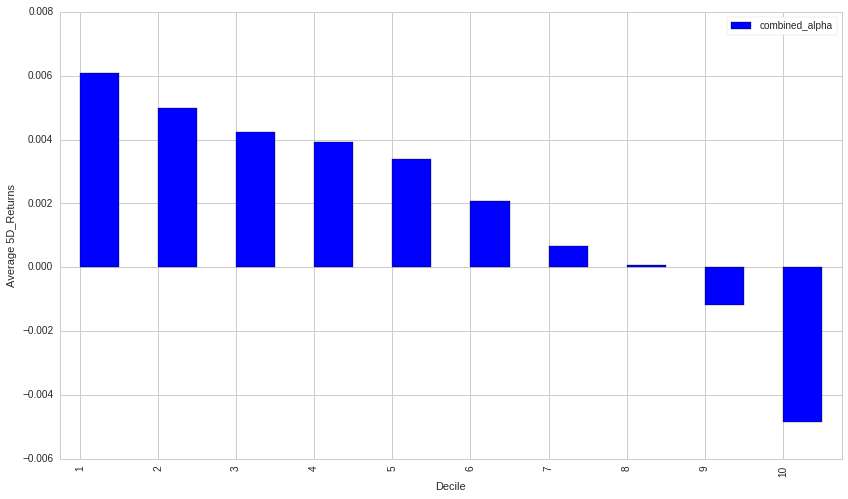

In [44]:
CA=alpha_df.groupby('CA_decile')['5D_Returns'].apply(lambda x: x.mean())
CA.plot(kind='bar', color='blue',  position=0, width=0.5,label='combined_alpha')
plt.xlabel('Decile')
plt.ylabel('Average 5D_Returns')
plt.legend(loc='best');

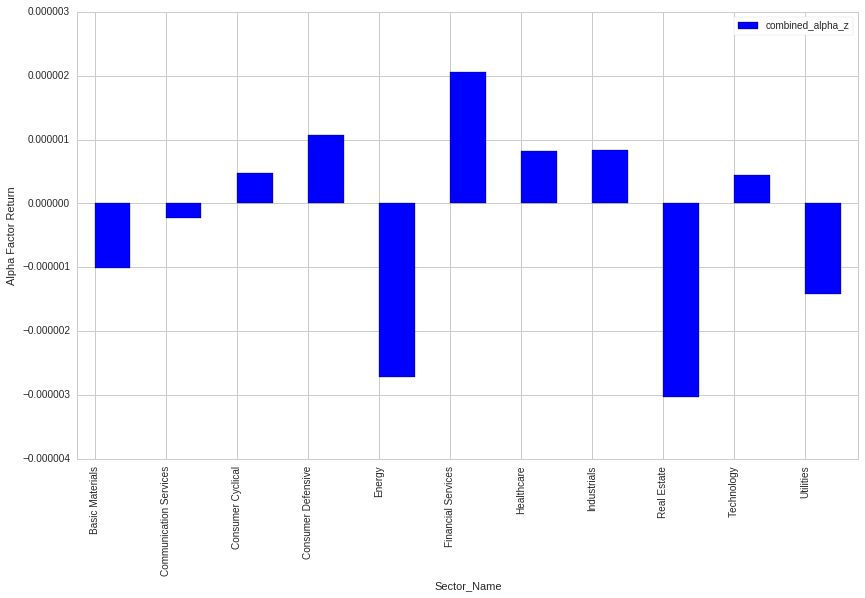

In [45]:
sector_averagesz = alpha_df.groupby('Sector_Name')['combined_alpha'].apply(lambda x: x.mean())
sector_averagesz.plot(kind='bar', color='blue',  position=0, width=0.5,label='combined_alpha_z')
plt.ylabel('Alpha Factor Return')
plt.legend(loc='best');

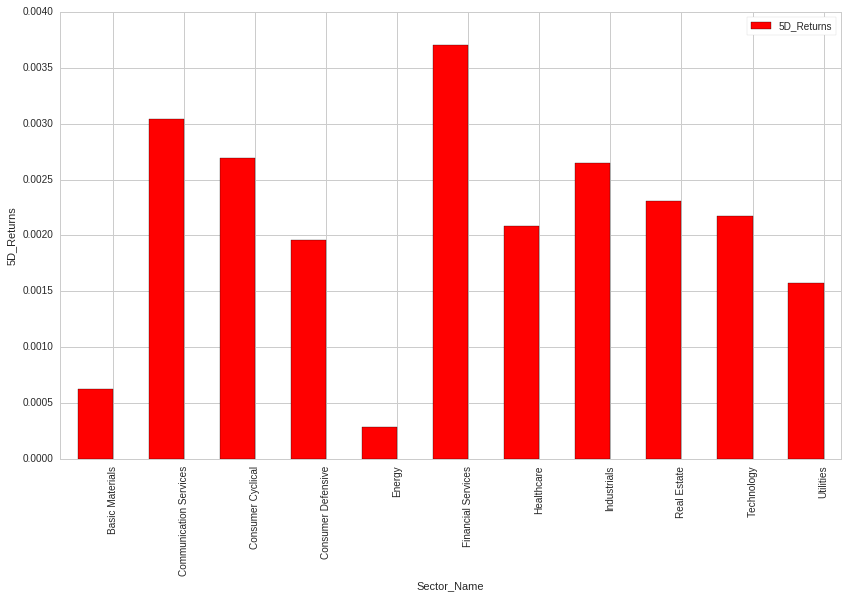

In [46]:
sector_averagesb = alpha_df.groupby('Sector_Name')['5D_Returns'].apply(lambda x: x.mean())
plt.ylabel('5D_Returns')
sector_averagesb.plot(kind='bar', color='red',  position=1, width=0.5,label='5D_Returns')
plt.legend(loc='best');

In [47]:
rets0 = alpha_df['5D_Returns']
alpha = alpha_df['combined_alpha']
alphaz = alpha_df['combined_alphaz']

In [48]:
print(alpha.describe().loc[['mean', 'std', 'min', 'max']])

mean    2.373815e-23
std     2.937507e-06
min    -2.842206e-05
max     1.106648e-05
Name: combined_alpha, dtype: float64


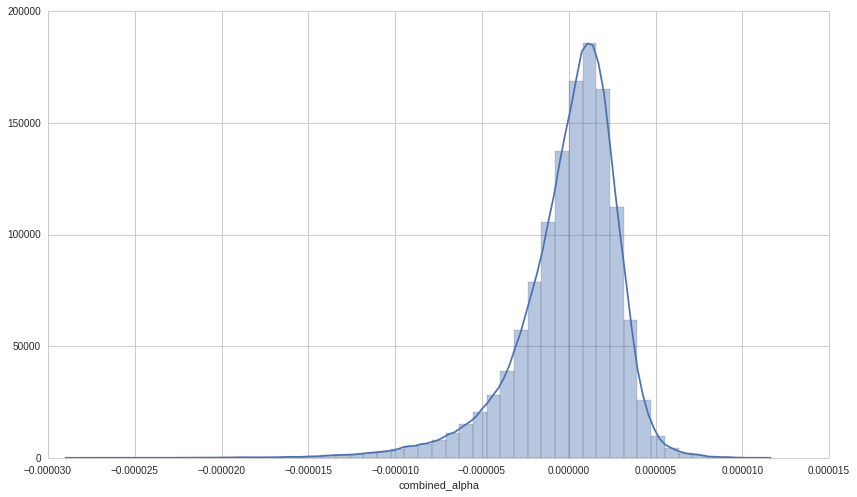

In [49]:
import seaborn as sns
sns.distplot(alpha);

In [50]:
r_s = stats.spearmanr(alpha, rets0)
print 'Correlation Coefficient: ' + str(r_s[0])
print 'p-value: ' + str(r_s[1])

Correlation Coefficient: -0.0757834657584
p-value: 0.0


In [51]:
df1 = alpha_df.drop('Sector_Name', axis=1)
df1.index = df1.index.droplevel(1)
df1.dropna()
df1.head(2)

combined_alpha  combined_alphaz  Sector  \
date                                                                 
2010-01-04 00:00:00+00:00       -0.000005        -2.143357     101   
2010-01-04 00:00:00+00:00        0.000001         0.669992     311   

                           5D_Returns  CA_decile  RET_decile  
date                                                          
2010-01-04 00:00:00+00:00   -0.014067          1           3  
2010-01-04 00:00:00+00:00    0.008756          7           6

In [52]:
x = sm.add_constant(rets0, prepend=False)
ols = sm.OLS(alphaz, x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [53]:
ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.005       
Dependent Variable: combined_alphaz  AIC:                1611458.1663
Date:               2019-05-03 06:15 BIC:                1611480.2676
No. Observations:   465387           Log-Likelihood:     -8.0573e+05 
Df Model:           1                F-statistic:        2369.       
Df Residuals:       465385           Prob (F-statistic): 0.00        
R-squared:          0.005            Scale:              1.8678      
-----------------------------------------------------------------------
              Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-----------------------------------------------------------------------
5D_Returns   -2.4431     0.0502   -48.6755   0.0000   -2.5415   -2.3447
const         0.0661     0.0020    32.9792   0.0000    0.0622    0.0701
---------------------------------------------------------------------
Omnibus:            139674.723      Durbin-Watson:         2.004     
Prob(Omnibus):      0.000           Jarque-Bera (JB):      550209.375
Skew:               -1.456          Prob(JB):              0.000     
Kurtosis:           7.461           Condition No.:         25        
=====================================================================

"""

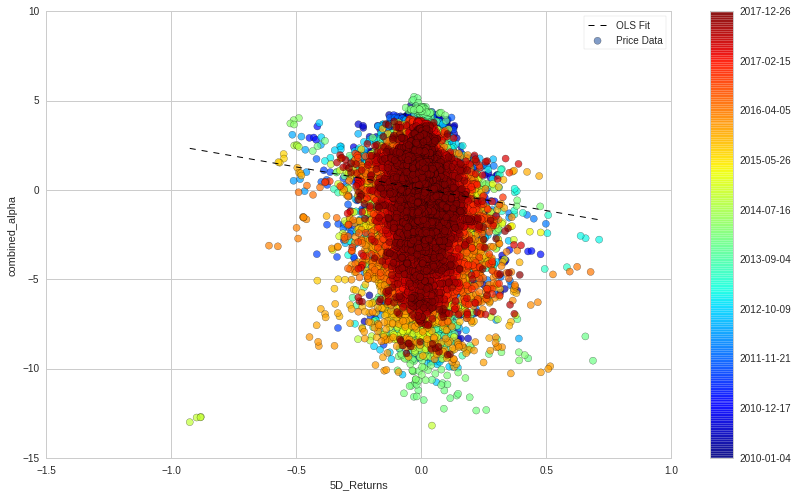

In [54]:
i = df1
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(alpha_df))
sc = plt.scatter(rets0, alphaz, s=50, c=colors, cmap=cm, 
                 edgecolor='k', alpha=0.7, label='Price Data')
plt.plot([x.min()[0], x.max()[0]], y_fit, 'black', linestyle='--', linewidth=1, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in i[::len(i)//9].index])
plt.xlabel('5D_Returns')
plt.ylabel('combined_alpha');

In [55]:
from quantopian.research.experimental import get_factor_returns, get_factor_loadings
import empyrical as ep
import pyfolio as pf

In [56]:
factor1_data = al.utils.get_clean_factor_and_forward_returns(
    factor=alpha_df["combined_alpha"],
    prices=pricing,
    groupby=alpha_df["Sector"],
    quantiles=5,
    periods=(1, 5, 10, 21)
)

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [57]:
sector_labels = dict(Sector.SECTOR_NAMES)
sector_labels[-1] = "Unknown" 

In [58]:
factor_loadings = get_factor_loadings(asset_list, start, end)
factor_returns = get_factor_returns(start, end)

In [59]:
def plot_ic_over_time(factor_data, label='', ax=None):
    mic = al.performance.mean_information_coefficient(factor_data)
    mic.index = mic.index.map(lambda x: int(x[:-1])) 
    ax = mic.plot(label=label, ax=ax)
    ax.set(xlabel='Days', ylabel='Mean IC')
    ax.legend()
    ax.axhline(0, ls='--', color='k')

In [60]:
def compute_specific_returns(total_returns, factor_returns=None, factor_loadings=None, assets=None):
    if assets is not None:
        factor_loadings = get_factor_loadings(assets, start, end + pd.Timedelta(days=30))
        factor_returns = get_factor_returns(start, end + pd.Timedelta(days=30))
    elif factor_loadings is None or factor_returns is None:
        raise ValueError('Supply either assets or factor_returns and factor_loadings')
    
    factor_returns.index = factor_returns.index.set_names(['dt'])
    factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
    common_returns = factor_loadings.mul(factor_returns).sum(axis='columns').unstack()
    specific_returns = total_returns - common_returns
    return specific_returns

In [61]:
stock_rets_specific = compute_specific_returns(stock_rets, factor_returns, factor_loadings)
cr_specific = ep.cum_returns(stock_rets_specific, starting_value=1)

In [62]:
factor_data_specific1 = al.utils.get_clean_factor_and_forward_returns(
    alpha_df["combined_alpha"], 
    cr_specific,
    periods=range(1, 21))

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [63]:
def factor_portfolio_returns(factor, pricing, equal_weight=True, delay=0):
    if equal_weight:
        factor = np.sign(factor)
        bins = (-1, 0, 1)
        quantiles = None
        zero_aware = False
    else:
        bins = None
        quantiles = 5
        zero_aware = True
        
    pos = factor.unstack().fillna(0)
    # Factor might not be daily, get trading index from pricing data and ffill
    pos = (pos / (pos.abs().sum())).reindex(pricing.index).ffill().shift(delay)
    # Fully invested, shorts show up as cash
    pos['cash'] = pos[pos < 0].sum(axis='columns')
    
    factor_and_returns = al.utils.get_clean_factor_and_forward_returns(
        pos.stack().loc[lambda x: x != 0], 
        pricing, periods=(1,), quantiles=quantiles, bins=bins, 
        zero_aware=zero_aware)
    
    return al.performance.factor_returns(factor_and_returns)['1D'], pos

portfolio_returns, portfolio_pos = factor_portfolio_returns(alpha_df["combined_alpha"], pricing, 
                                                             equal_weight=True)

Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [64]:
factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
portfolio_pos.index = portfolio_pos.index.set_names(['dt'])
risk_exposures_portfolio, perf_attribution = pf.perf_attrib.perf_attrib(
    portfolio_returns, 
    portfolio_pos, 
    factor_returns, 
    factor_loadings, 
    pos_in_dollars=False)

/usr/local/lib/python2.7/dist-packages/pyfolio/perf_attrib.py:589: UserWarning: Could not find factor loadings for 19 dates: (first missing is 2017-12-26 00:00:00+00:00, last missing is 2018-01-23 00:00:00+00:00). Truncating date range for performance attribution. 
  warnings.warn(warning_msg)


In [65]:
factor1_returns, factor1_positions, factor1_benchmark = \
    al.performance.create_pyfolio_input(factor1_data,
                                        period='5D',
                                        capital=10000000,
                                        long_short=True,
                                        group_neutral=False,
                                        equal_weight=True,
                                        quantiles=[1,5],
                                        groups=None,
                                        benchmark_period='1D')

/usr/local/lib/python2.7/dist-packages/alphalens/performance.py:541: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


In [66]:
asset_list = factor1_data.index.levels[1].unique()
start_date = factor1_data.index.levels[0].min()
end_date   = factor1_data.index.levels[0].max()
factor_loadings.index.names = ['dt', 'ticker']

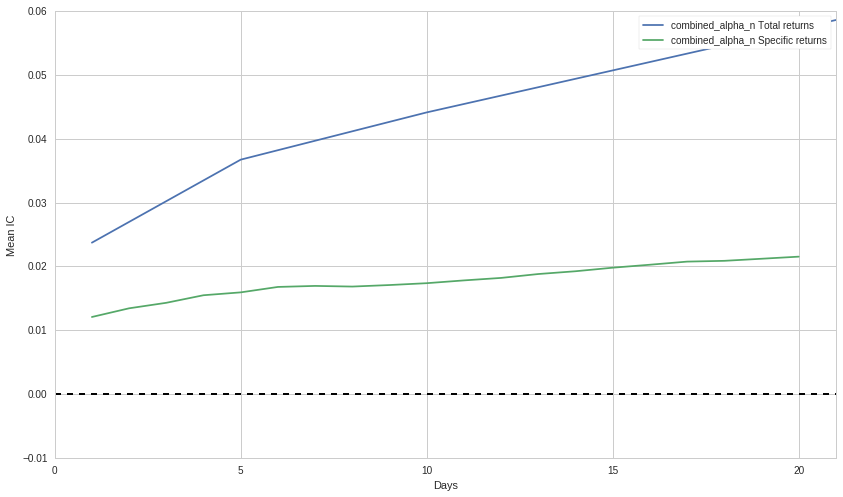

In [68]:
plot_ic_over_time(factor1_data, label='combined_alpha_n Total returns')
plot_ic_over_time(factor_data_specific1, label='combined_alpha_n Specific returns')

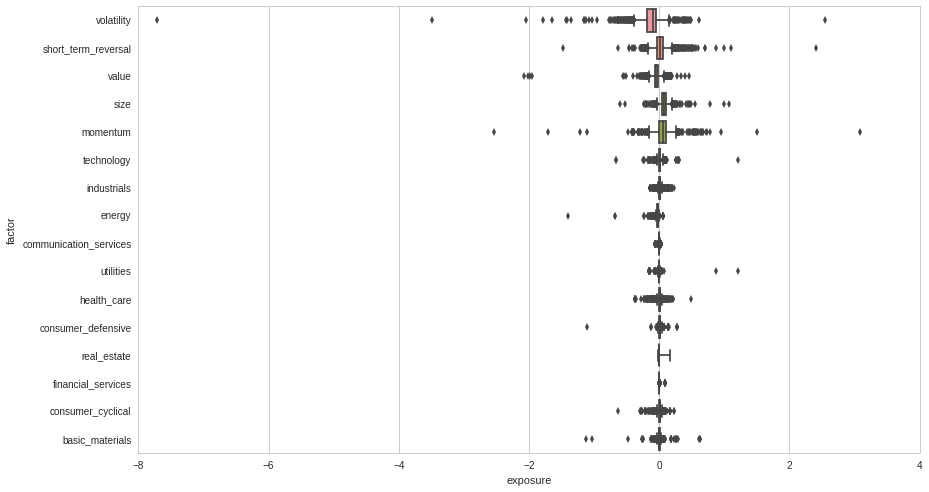

In [69]:
def plot_exposures(risk_exposures, ax=None):
    rep = risk_exposures.stack().reset_index()
    rep.columns = ['dt', 'factor', 'exposure']
    sns.boxplot(x='exposure', y='factor', data=rep, orient='h', ax=ax, order=risk_exposures.columns[::-1])
    
plot_exposures(risk_exposures_portfolio)

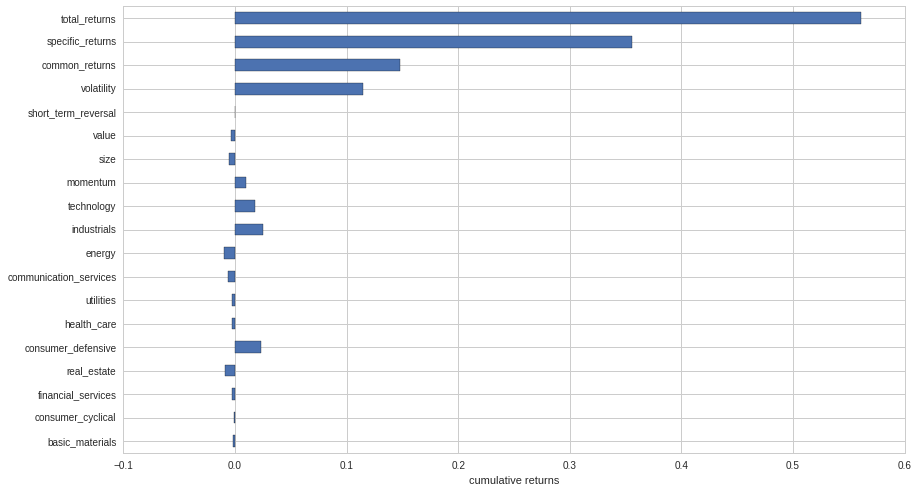

In [70]:
ep.cum_returns_final(perf_attribution).plot.barh()
plt.xlabel('cumulative returns');

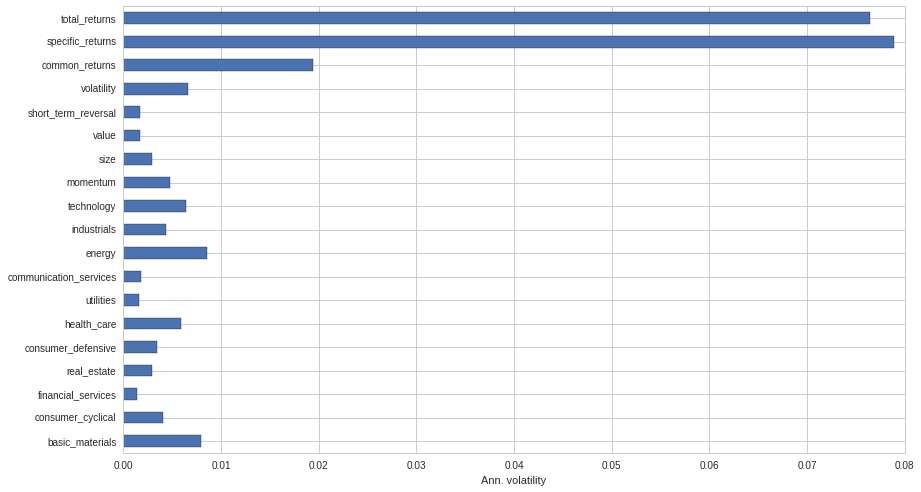

In [71]:
perf_attribution.apply(ep.annual_volatility).plot.barh()
plt.xlabel('Ann. volatility');

Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


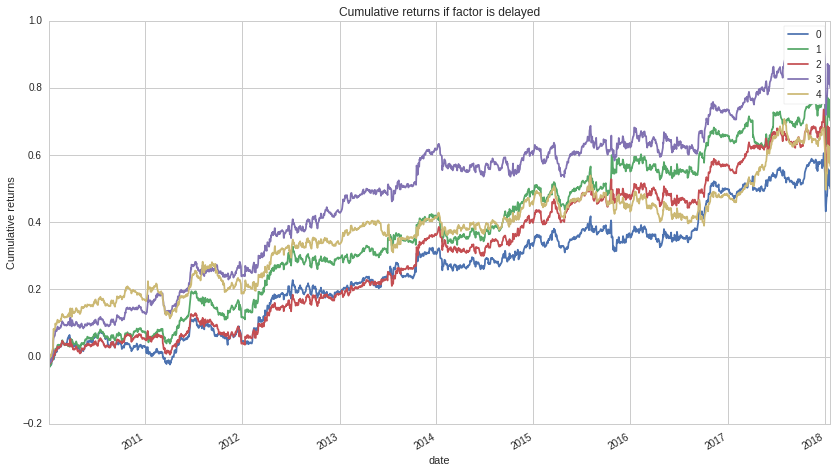

In [72]:
def plot_cum_returns_delay(factor, pricing, delay=range(5), ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for d in delay:
        portfolio_returns, _ = factor_portfolio_returns(alpha_df["combined_alpha"], pricing, delay=d)
        ep.cum_returns(portfolio_returns).plot(ax=ax, label=d)
    ax.legend()
    ax.set(ylabel='Cumulative returns', title='Cumulative returns if factor is delayed')
    
plot_cum_returns_delay(alpha_df["combined_alpha"], pricing)

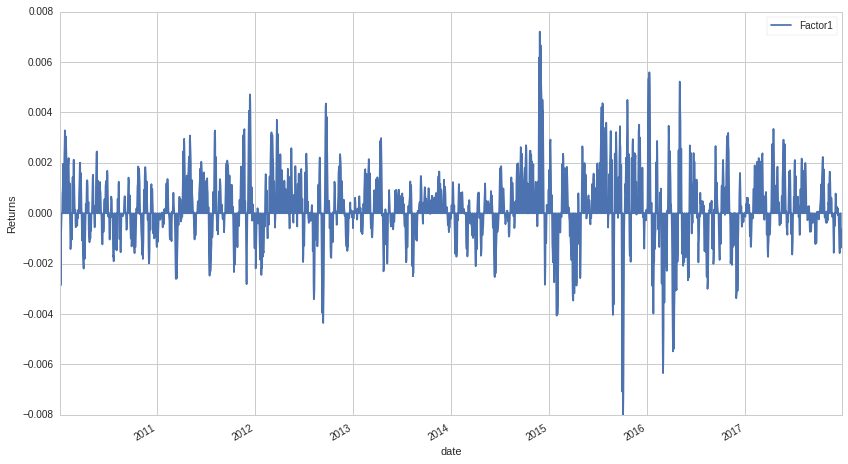

In [73]:
factor1_returns.plot()
plt.ylabel('Returns')
plt.legend(['Factor1']);

/usr/local/lib/python2.7/dist-packages/pyfolio/perf_attrib.py:589: UserWarning: Could not find factor loadings for 906 dates: (first missing is 2010-01-09 00:00:00+00:00, last missing is 2017-12-27 00:00:00+00:00). Truncating date range for performance attribution. 
  warnings.warn(warning_msg)


## Performance Relative to Common Risk Factors

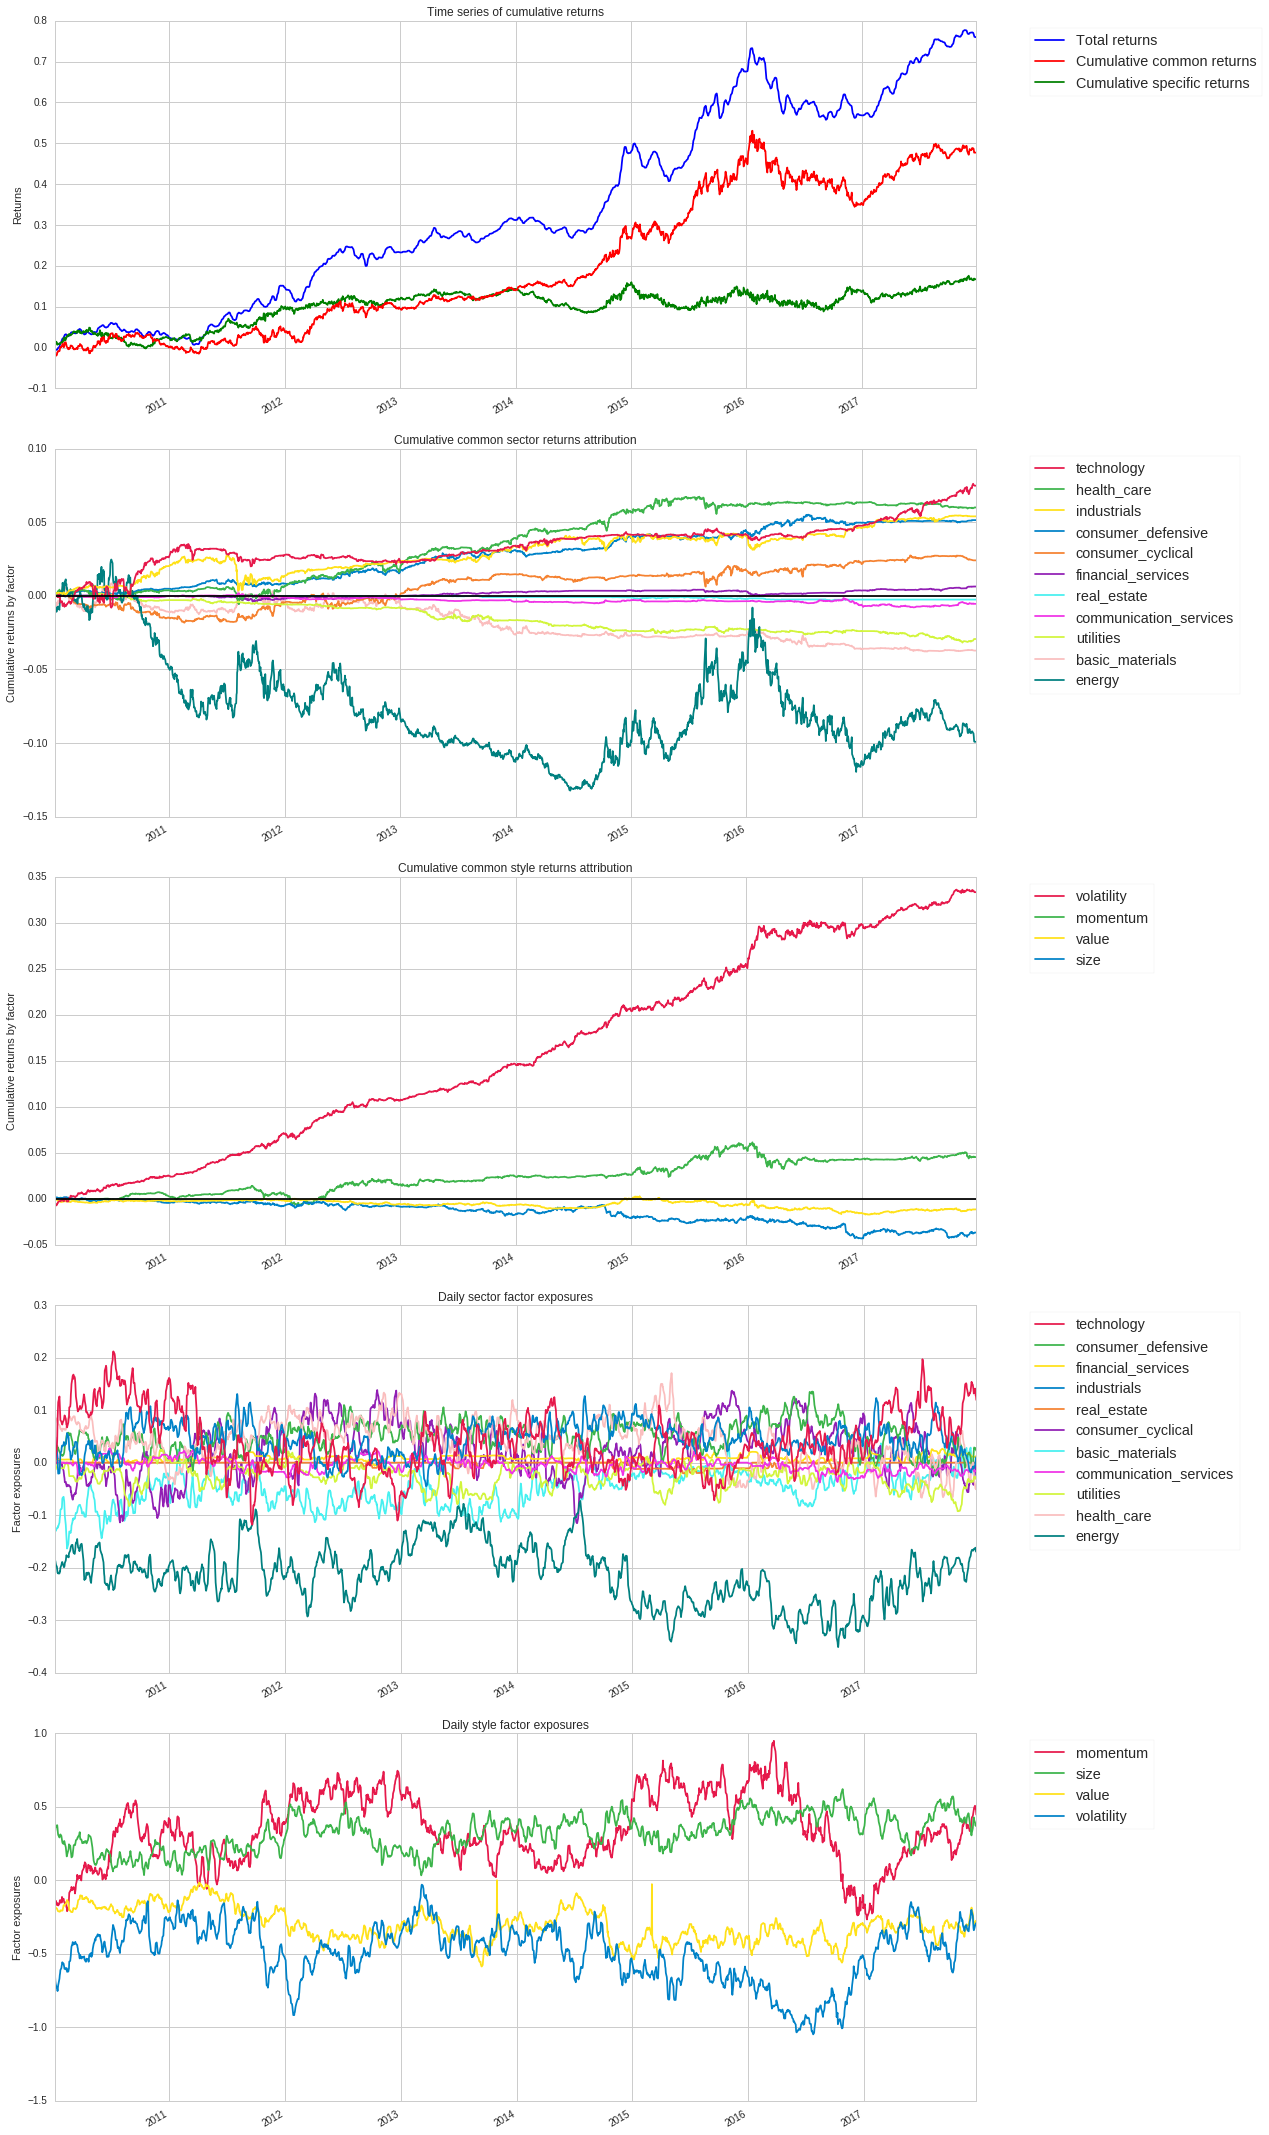

In [74]:
pf.tears.create_perf_attrib_tear_sheet(factor1_returns,
                                       positions=factor1_positions,
                                       factor_returns=factor_returns,
                                       factor_loadings=factor_loadings,      
                                       pos_in_dollars=True)

In [75]:
my_factor1 = alpha_df['combined_alpha']
sectors = alpha_df['Sector']
prices = pricing
periods = (1,3,5,10,21)

factor_data1 = al.utils.get_clean_factor_and_forward_returns(factor=my_factor1,
                                                            prices=prices,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=periods,
                                                            quantiles = 5)

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


min           max          mean           std  \
factor_quantile                                                           
1               -2.661400e-05 -9.910896e-07 -4.436868e-06  2.739276e-06   
2               -2.660633e-06  4.406666e-07 -8.827072e-07  5.366444e-07   
3               -5.396822e-07  1.630957e-06  5.124332e-07  3.741175e-07   
4                5.487952e-07  2.901875e-06  1.616829e-06  3.738722e-07   
5                1.547211e-06  1.106648e-05  3.224105e-06  9.958182e-07   

                 count    count %  
factor_quantile                    
1                93693  20.172676  
2                92491  19.913878  
3                92497  19.915169  
4                92491  19.913878  
5                93283  20.084400

Returns Analysis


1D     3D     5D    10D  \
Ann. alpha                                     0.095  0.096  0.096  0.101   
beta                                          -0.178 -0.200 -0.215 -0.224   
Mean Period Wise Return Top Quantile (bps)     2.684  2.669  2.682  2.597   
Mean Period Wise Return Bottom Quantile (bps) -3.148 -3.109 -3.161 -3.252   
Mean Period Wise Spread (bps)                  5.832  5.862  5.941  5.959   

                                                 21D  
Ann. alpha                                     0.108  
beta                                          -0.233  
Mean Period Wise Return Top Quantile (bps)     2.477  
Mean Period Wise Return Bottom Quantile (bps) -3.371  
Mean Period Wise Spread (bps)                  5.966

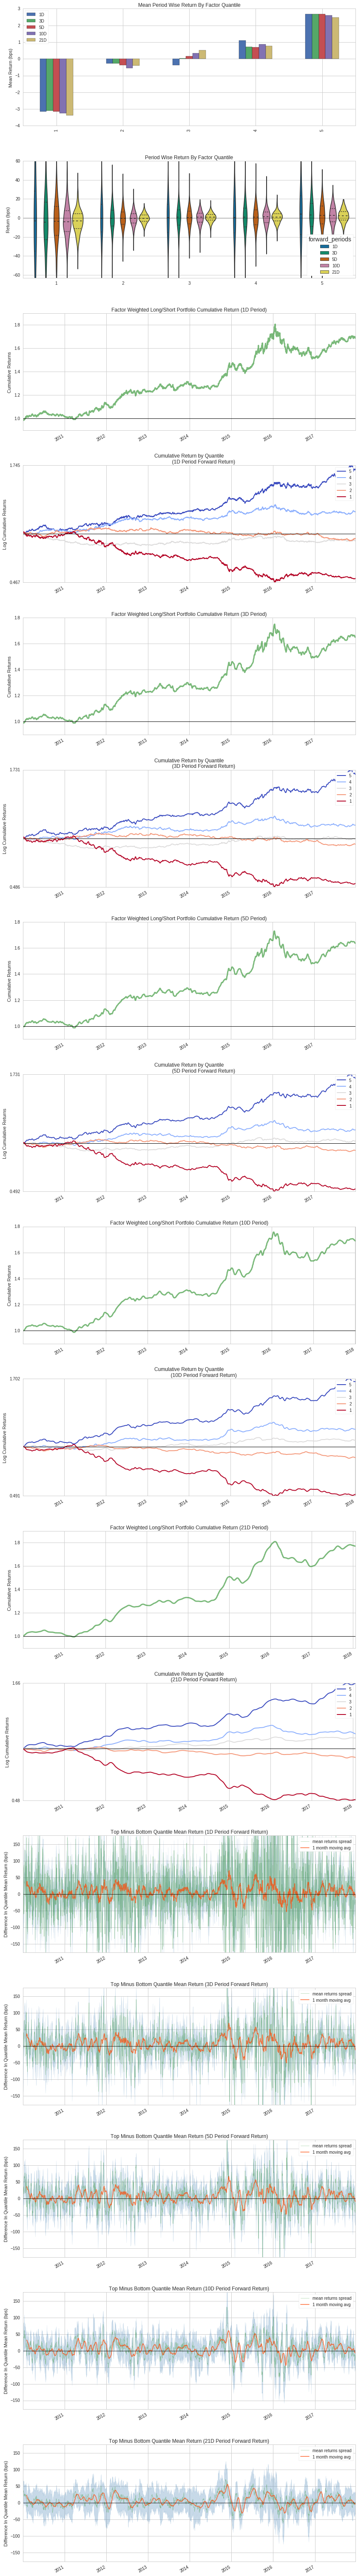

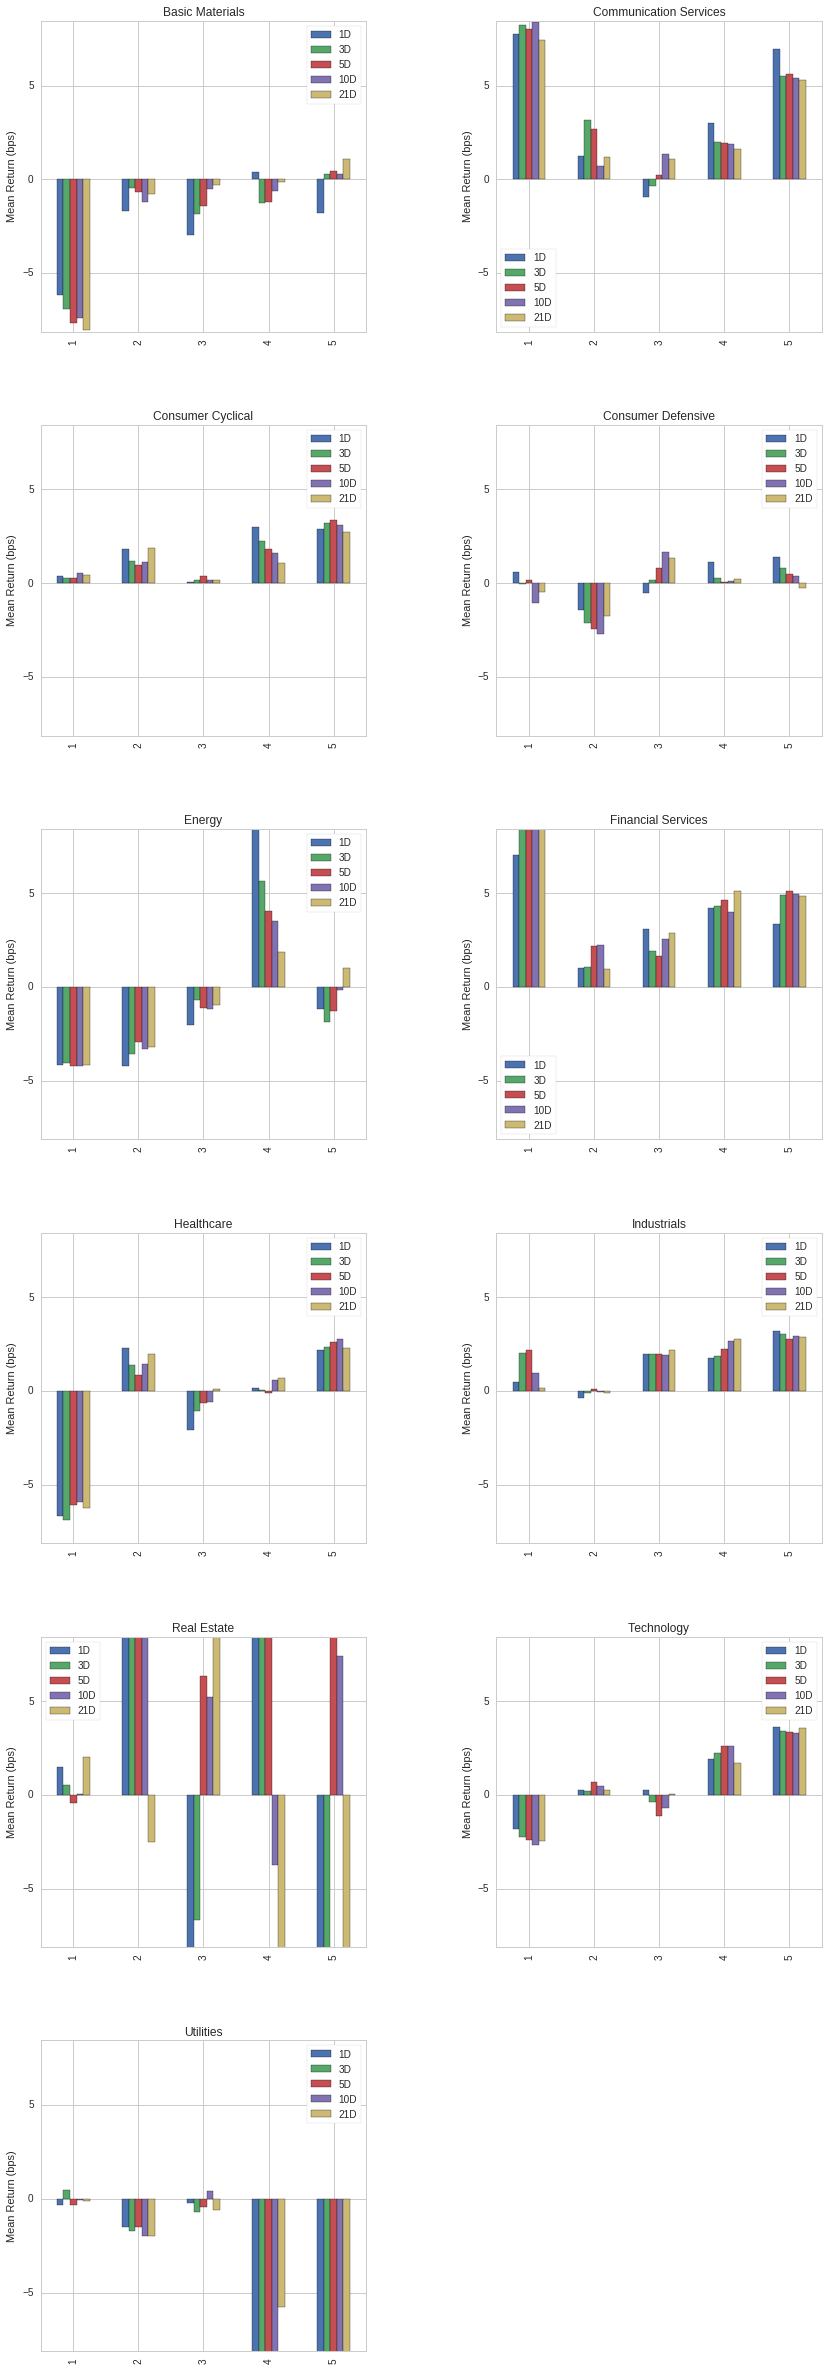

Information Analysis


1D     3D      5D     10D     21D
IC Mean           0.024  0.032   0.037   0.044   0.059
IC Std.           0.165  0.159   0.158   0.158   0.152
Risk-Adjusted IC  0.144  0.200   0.233   0.279   0.386
t-stat(IC)        6.466  8.973  10.456  12.520  17.312
p-value(IC)       0.000  0.000   0.000   0.000   0.000
IC Skew          -0.054 -0.084  -0.048  -0.088  -0.024
IC Kurtosis      -0.369 -0.425  -0.391  -0.496  -0.321

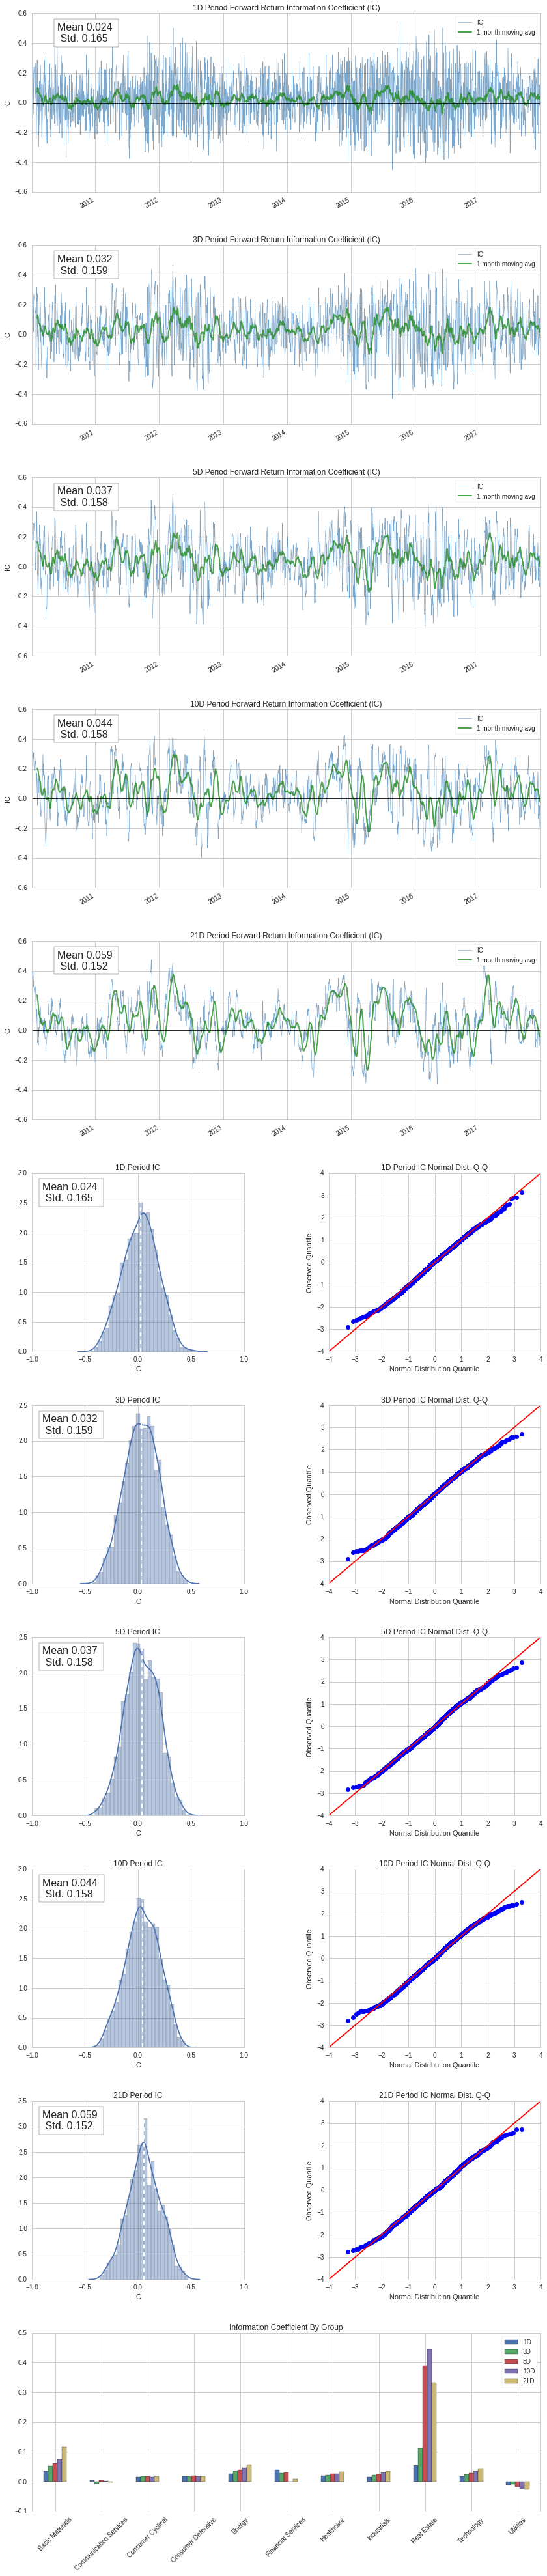

Turnover Analysis


10D     1D    21D     3D     5D
Quantile 1 Mean Turnover   0.240  0.060  0.337  0.122  0.170
Quantile 2 Mean Turnover   0.444  0.139  0.565  0.262  0.347
Quantile 3 Mean Turnover   0.523  0.181  0.631  0.332  0.428
Quantile 4 Mean Turnover   0.503  0.176  0.610  0.321  0.414
Quantile 5 Mean Turnover   0.299  0.085  0.407  0.164  0.223

1D     3D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.989  0.965  0.942  0.903  0.829

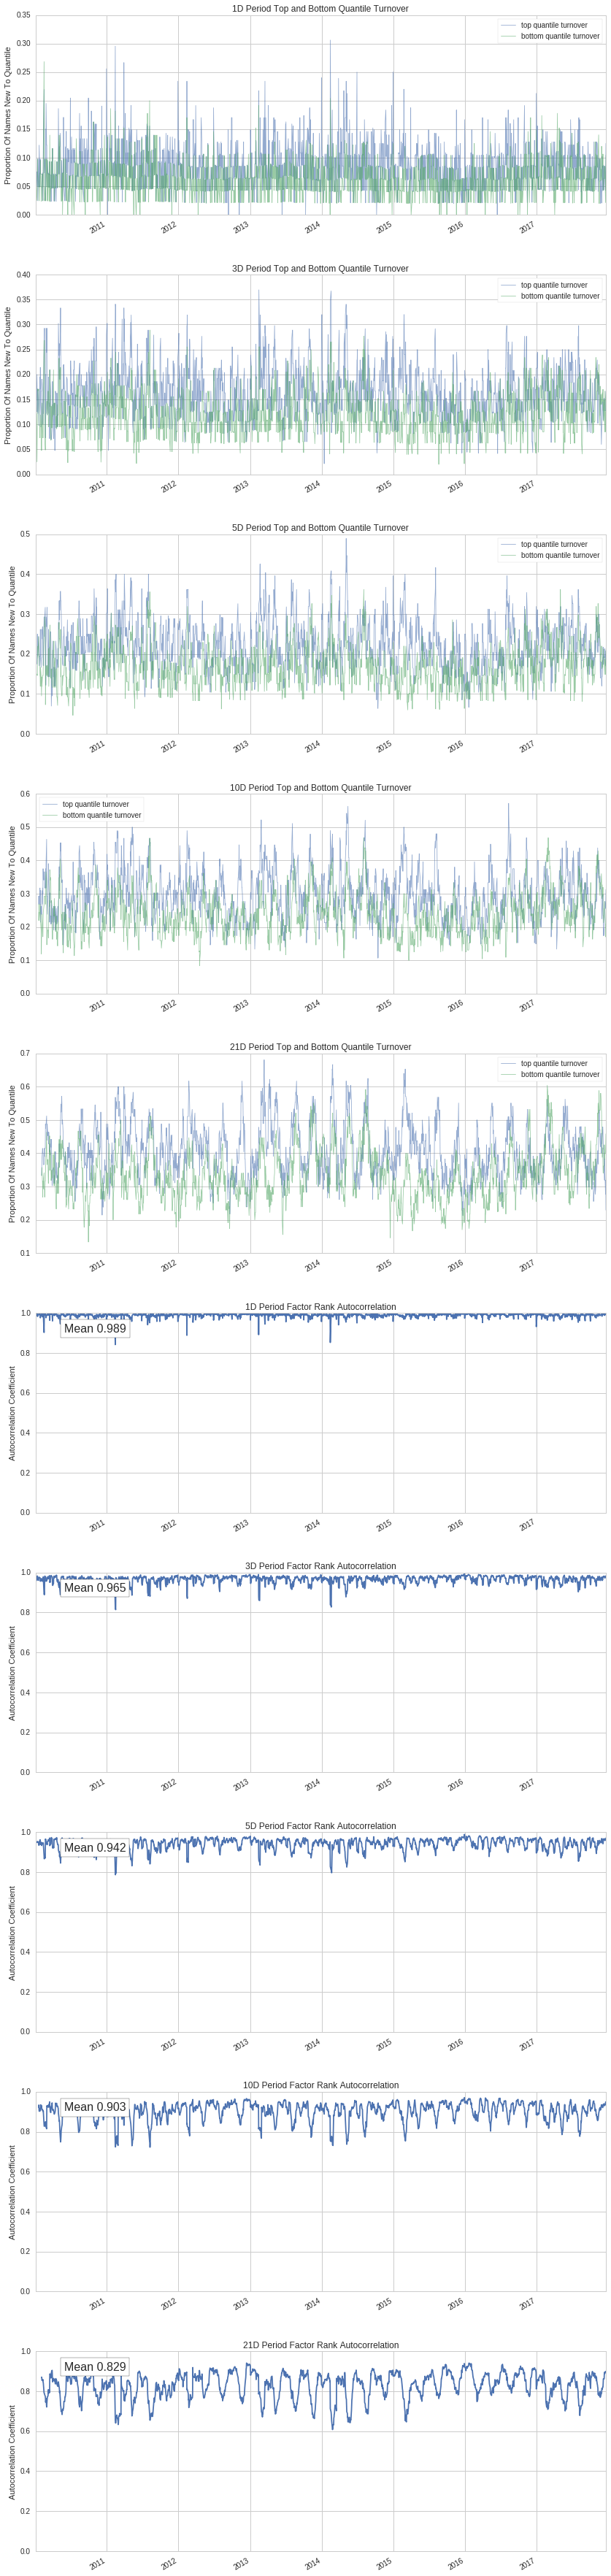

In [76]:
al.tears.create_full_tear_sheet(factor_data1, by_group=True);

Information Analysis


1D     3D      5D     10D     21D
IC Mean           0.024  0.032   0.037   0.044   0.059
IC Std.           0.165  0.159   0.158   0.158   0.152
Risk-Adjusted IC  0.144  0.200   0.233   0.279   0.386
t-stat(IC)        6.466  8.973  10.456  12.520  17.312
p-value(IC)       0.000  0.000   0.000   0.000   0.000
IC Skew          -0.054 -0.084  -0.048  -0.088  -0.024
IC Kurtosis      -0.369 -0.425  -0.391  -0.496  -0.321

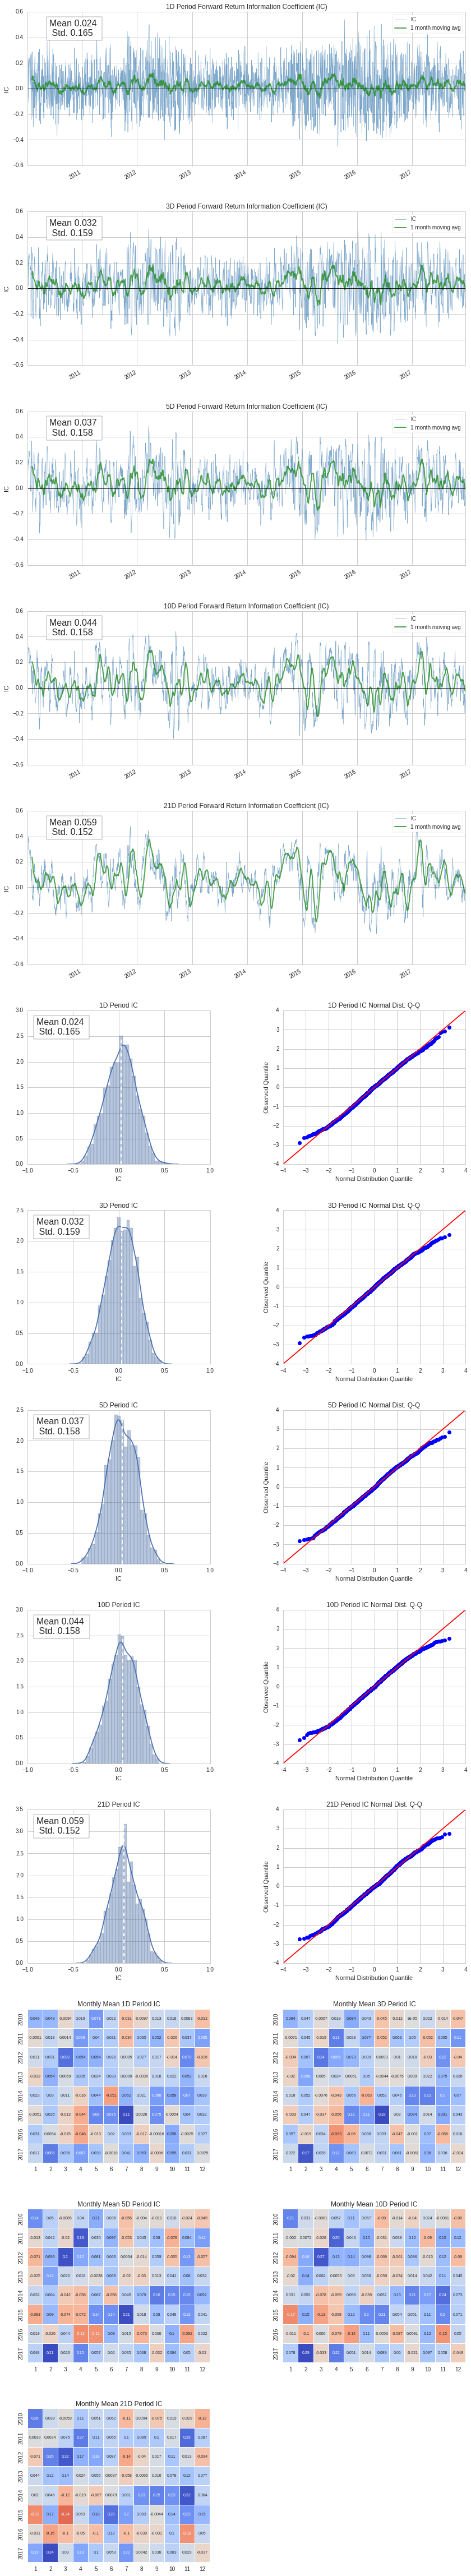

In [77]:
al.tears.create_information_tear_sheet(factor_data1)

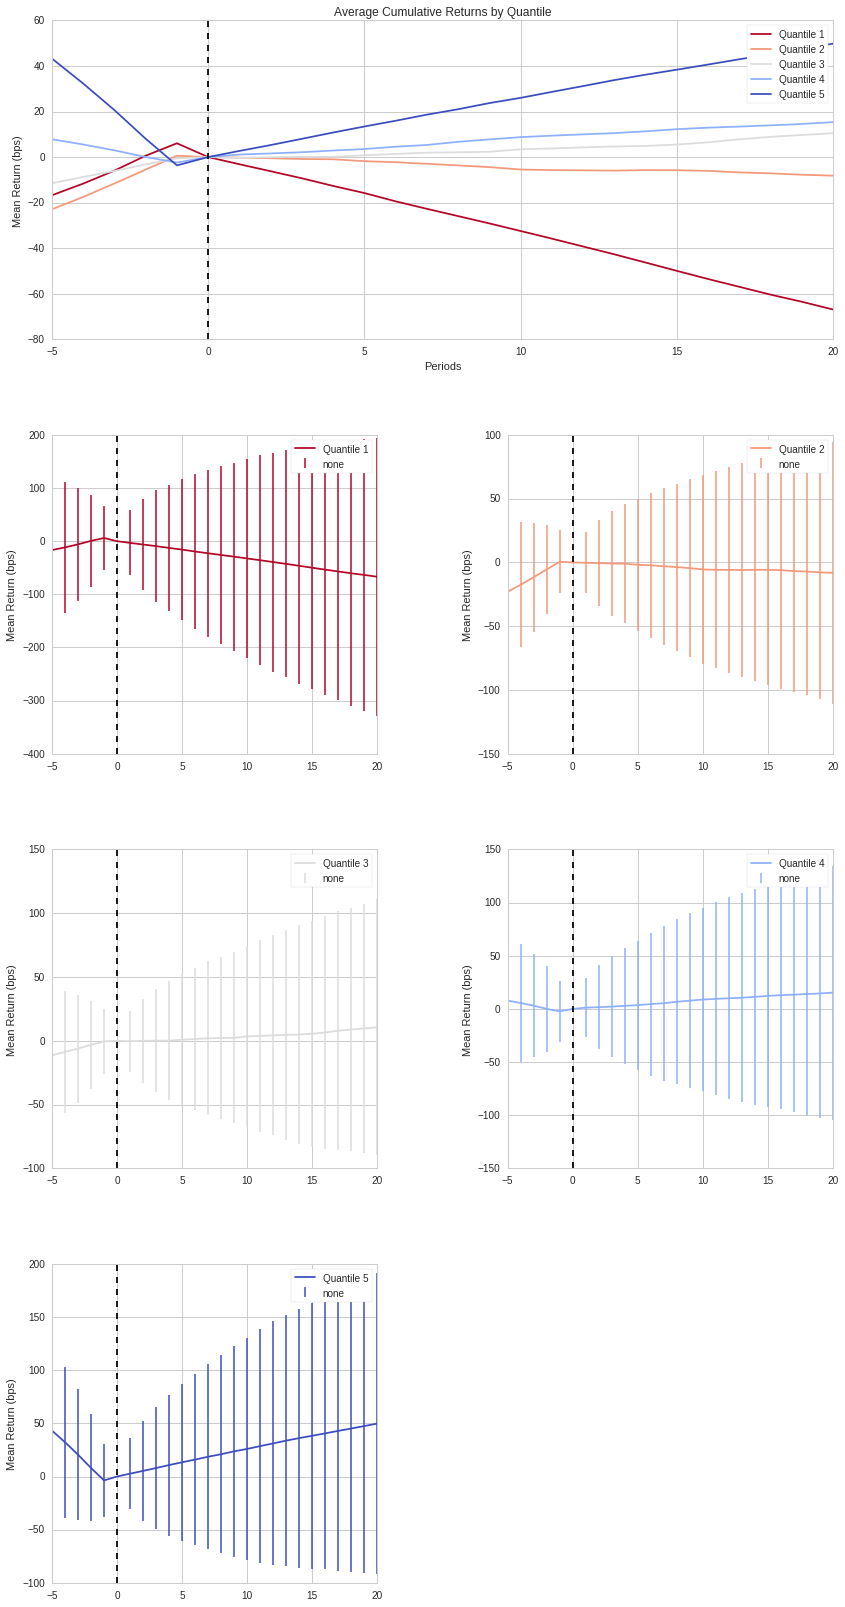

In [ ]:
al.tears.create_event_returns_tear_sheet(factor_data=factor_data1,
                                                        prices=prices,
                                                        avgretplot=(5, 20),
                                                        long_short=True,
                                                        by_group=True);